In [1]:
import tensorflow as tf
from keras.optimizer_v1 import SGD
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from glob import glob
import matplotlib.pyplot as plt

In [2]:
# OCT images of 1024 x 1024 pixels with 1 channel
IMG_ROWS=224; IMG_COLS=224; IMG_CHANNELS=1
IMAGE_SIZE = [IMG_ROWS, IMG_COLS]


In [3]:
WHICH_MODEL = 'DenseNet121'

if WHICH_MODEL == 'VGG16':
    from keras.applications.vgg16 import VGG16
    from keras.applications.vgg16 import preprocess_input

    # for RGB channel use [3], for black and white use one channel [1], and IMAGE_SIZE + [3] = [224, 224, 3]
    orig_model = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    LEARN_RATE = 0.0001
    OCT_MODEL_NAME = 'VGG16_oct_minipigs.h5'

elif WHICH_MODEL == 'VGG19':
    from keras.applications.vgg19 import VGG19
    from keras.applications.vgg19 import preprocess_input

    # for RGB channel use [3], for black and white use one channel [1]
    orig_model = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    LEARN_RATE = 0.0001
    OCT_MODEL_NAME = 'VGG19_oct_minipigs.h5'

elif WHICH_MODEL == 'ResNet50':
    from keras.applications.resnet50 import ResNet50
    from keras.applications.resnet50 import preprocess_input

    orig_model = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    LEARN_RATE = 0.001
    OCT_MODEL_NAME = 'ResNet50_oct_minipigs.h5'

elif WHICH_MODEL == 'InceptionV3':
    from keras.applications.inception_v3 import InceptionV3
    from keras.applications.inception_v3 import preprocess_input

    orig_model = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    LEARN_RATE = 0.0001
    OCT_MODEL_NAME = 'InceptionV3_oct_minipigs.h5'

elif WHICH_MODEL == 'DenseNet121':
    from keras.applications.densenet import DenseNet121
    from keras.applications.densenet import preprocess_input

In [4]:
orig_model = DenseNet121(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
LEARN_RATE = 0.0001
OCT_MODEL_NAME = 'DenseNet121_oct_minipigs.h5'


In [5]:
BATCH_SIZE = 32

EPOCHS = 20

In [6]:
# path to TRAINING dataset of the OCT images
TRAIN_PATH = 'C:\\Users\\Ali\Documents\\minipigs_images\\Split_Data\\train'

# path to VALIDATE dataset of the OCT images
VALID_PATH = 'C:\\Users\\Ali\\Documents\\minipigs_images\\Split_Data\\val'

# path to TESTING dataset of the OCT images
TEST_PATH = 'C:\\Users\\Ali\\Documents\\minipigs_images\\Split_Data\\test'

DATASET = 'Minipigs'

CLASS_MODE = 'categorical'   # binary, categorical

NUMBER_OF_CLASSES = 5


In [7]:

adam = Adam(learning_rate=LEARN_RATE)
#adam = Adam(learning_rate=LEARN_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam', decay=LEARN_RATE/EPOCHS)

#sgd = SGD(learning_rate=LEARN_RATE)

OPTIMISATION = adam  # SGD

# no need to train the weights again
for layer in orig_model.layers[:-5]:
    layer.trainable = False

In [8]:
# to retrieve the number of classes
folders = glob(TRAIN_PATH + '/*')

In [9]:
# more layers could be added to the model
x = Flatten()(orig_model.output)
x = Dropout(0.3)(x)

prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=orig_model.input, outputs=prediction)

In [10]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [11]:
# tell the model what cost and optimisation method to use
model.compile(
    loss='categorical_crossentropy',
    optimizer=OPTIMISATION,
    metrics=['accuracy']
)

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=350, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.15, zoom_range=0.1,
    channel_shift_range=10., horizontal_flip=True, fill_mode='constant'
)

In [13]:
training_set = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_ROWS, IMG_COLS),
    batch_size=BATCH_SIZE,
#    seed=42,
#    color_mode=COLOUR_MODE,
    class_mode=CLASS_MODE
)

Found 210 images belonging to 5 classes.


In [14]:
valid_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=350, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.15, zoom_range=0.1,
    channel_shift_range=10., horizontal_flip=True, fill_mode='constant'
)

In [15]:
valid_set = valid_datagen.flow_from_directory(
    VALID_PATH,
    target_size=(IMG_ROWS, IMG_COLS),
    batch_size=BATCH_SIZE,
#    seed=42,
#    color_mode=COLOUR_MODE,
    class_mode=CLASS_MODE
)

Found 60 images belonging to 5 classes.


In [16]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_set = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_ROWS, IMG_COLS),
    batch_size=BATCH_SIZE,
#    seed=42,
#    color_mode=COLOUR_MODE,
    class_mode=CLASS_MODE
)

Found 35 images belonging to 5 classes.


In [17]:
# fit the model
history = model.fit(
    training_set,
    validation_data=valid_set,
    epochs=EPOCHS,
    steps_per_epoch=len(training_set),
#    validation_split=0.1
    validation_steps=len(valid_set)
)

Epoch 1/20
7/7 [==============================] - 38s 5s/step - loss: 2.7367 - accuracy: 0.1714 - val_loss: 2.5596 - val_accuracy: 0.2000
Epoch 2/20
7/7 [==============================] - 26s 4s/step - loss: 2.4154 - accuracy: 0.2143 - val_loss: 1.8886 - val_accuracy: 0.3667
Epoch 3/20
7/7 [==============================] - 25s 4s/step - loss: 2.2280 - accuracy: 0.2857 - val_loss: 1.8525 - val_accuracy: 0.3667
Epoch 4/20
7/7 [==============================] - 29s 4s/step - loss: 2.1077 - accuracy: 0.3333 - val_loss: 1.9198 - val_accuracy: 0.3000
Epoch 5/20
7/7 [==============================] - 27s 4s/step - loss: 2.0689 - accuracy: 0.3762 - val_loss: 1.6603 - val_accuracy: 0.4000
Epoch 6/20
7/7 [==============================] - 25s 4s/step - loss: 1.8802 - accuracy: 0.3762 - val_loss: 1.3349 - val_accuracy: 0.4667
Epoch 7/20
7/7 [==============================] - 25s 4s/step - loss: 1.7266 - accuracy: 0.4429 - val_loss: 1.3258 - val_accuracy: 0.4333
Epoch 8/20
7/7 [==================

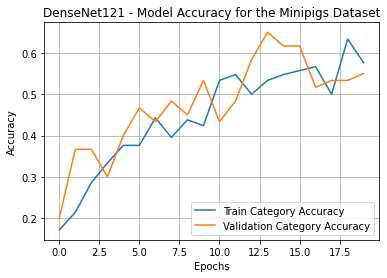

In [18]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
acc_title = "{} - Model Accuracy for the {} Dataset".format(WHICH_MODEL, DATASET)
plt.title(acc_title)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend(['Train Category Accuracy', 'Validation Category Accuracy'], loc='lower right')
plt.show()

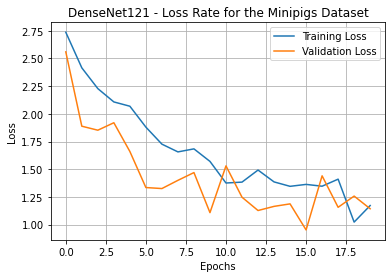

In [19]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
loss_title = "{} - Loss Rate for the {} Dataset".format(WHICH_MODEL, DATASET)
plt.title(loss_title)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

In [20]:
train_loss, train_acc = model.evaluate(training_set, steps=16)
valid_loss, valid_acc = model.evaluate(valid_set, steps=16)

print('\nLearn Rate =', LEARN_RATE, ', Epochs =', EPOCHS, ', Training Folder =', TRAIN_PATH)

print('Validation Folder =', VALID_PATH, ', Test Folder =', TEST_PATH)

print('\nTraining: %.3f, Validation: %.3f' % (train_acc, valid_acc))

print('\nThe processing of Convolutional Neural Networks with Transfer Learning for', WHICH_MODEL, 'succeed.\n')

16/16 [==============================] - 7s 169ms/step - loss: 0.9566 - accuracy: 0.6167

Learn Rate = 0.0001 , Epochs = 20 , Training Folder = C:\Users\Ali\Documents\minipigs_images\Split_Data\train
Validation Folder = C:\Users\Ali\Documents\minipigs_images\Split_Data\val , Test Folder = C:\Users\Ali\Documents\minipigs_images\Split_Data\test

Training: 0.733, Validation: 0.617

The processing of Convolutional Neural Networks with Transfer Learning for DenseNet121 succeed.



In [21]:
results = model.evaluate(test_set, steps=16)
print("\nTest loss and accuracy are:", results)

16/16 [==============================] - 4s 25ms/step - loss: 0.9822 - accuracy: 0.5714

Test loss and accuracy are: [0.9821720719337463, 0.5714285969734192]


In [22]:
model.save('model_-5layers_0.3dropout_20epochs.h5')


Predictions:

[[8.8039991e-03 3.0641141e-03 1.9297169e-01 2.4242108e-03 7.9273599e-01]
 [3.9634141e-03 2.1656066e-02 2.8192484e-01 2.7933465e-02 6.6452223e-01]
 [6.7527145e-02 8.8076115e-01 4.6481504e-03 3.4556679e-02 1.2506923e-02]
 [3.1553354e-02 4.0744726e-02 6.7478460e-01 1.4299168e-01 1.0992560e-01]
 [9.9819161e-02 6.3295275e-01 1.1680831e-02 1.5417381e-02 2.4012993e-01]
 [1.8761678e-01 2.7667993e-01 8.4537528e-02 4.0097460e-03 4.4715595e-01]
 [2.2850551e-02 3.9790716e-02 1.1461544e-01 1.6365817e-01 6.5908509e-01]
 [6.1250012e-02 8.8225448e-01 5.8252094e-03 4.7643378e-02 3.0269318e-03]
 [6.1312622e-01 1.5236048e-01 3.4969060e-03 2.3989892e-03 2.2861734e-01]
 [2.8647020e-01 1.3178680e-02 6.7634452e-03 1.6417766e-03 6.9194591e-01]
 [1.3588797e-03 7.4361120e-03 9.2960227e-01 2.3486526e-03 5.9254184e-02]
 [1.2167517e-01 2.7772588e-01 1.0672356e-01 4.5349759e-01 4.0377852e-02]
 [2.1899372e-02 8.6025603e-02 4.1615907e-02 4.3228015e-02 8.0723107e-01]
 [1.5377873e-01 1.0825182e-02 4.0544

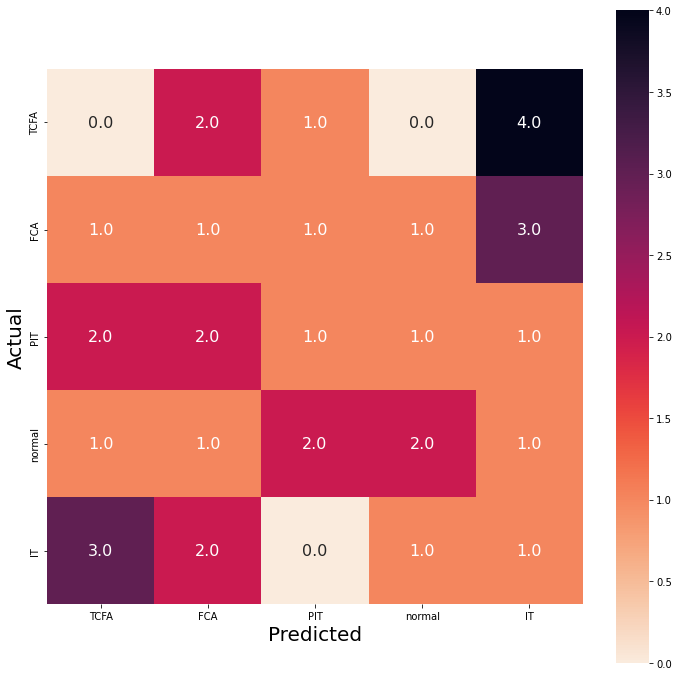

In [26]:
cnn_predictions = model.predict(test_set)
print('\nPredictions:\n')
print(cnn_predictions)

cnn_predictions_max = cnn_predictions.argmax(axis=1)
print('\nPredictions argmax(axis=1):\n')
print(cnn_predictions_max)

print(test_set.labels)

print('\nTesting execution ended.\n')

import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

label = ['TCFA', 'FCA', 'PIT', 'normal', 'IT']
#Ypred = np.argmax(cnn_predictions, axis=1)
#Ytrue = np.argmax(test_set.labels, axis=0)

cm = confusion_matrix(test_set.labels, cnn_predictions_max)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)
plt.show()